In [1]:
#Librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
import matplotlib as mpl
from pathlib import Path, PurePath #manejo de rutas y archivos

idioma = 'español'
#idioma = 'ingles'

#Graficación

if idioma == 'español':
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    #axes.prop_cycle : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e'])
    #Latex y coma como separador decimal
    plt.rcParams['text.usetex'] = True #latex
    #plt.rc('text', usetex=False)
    plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
    #se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx}') 
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })
    import locale #líbreria para el formato
    locale.setlocale(locale.LC_ALL, "es_CR.utf8")

if idioma == 'ingles' :
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{siunitx}')
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })



import findiff as ff #derivada https://github.com/maroba/findiff

### Cálculo de coeficientes para el perfil de presión con VMEC - para Input

A partir de los perfiles de densidad y temperatura, es posible estimar la presión con la ley del gas ideal
$$ p(s) = n_e (s) \cdot T_e (s) \cdot 1.60 \times 10^{-19} $$ con pe en pascales, Te en electronvolts y ne en m^{-3}. Una vez calculada la presión, se ajusta a un polinomio de la forma
$$ p(n) =  \sum_{n=0}^{10} a_m(n) \cdot s^n $$

[ 6.91943045e+00 -4.47868295e+01  1.15591495e+02 -1.52951547e+02
  1.10215114e+02 -4.35142123e+01  1.11283055e+01 -2.86488097e+00
  8.64238830e-02 -2.69465913e-03  1.79678929e-01]


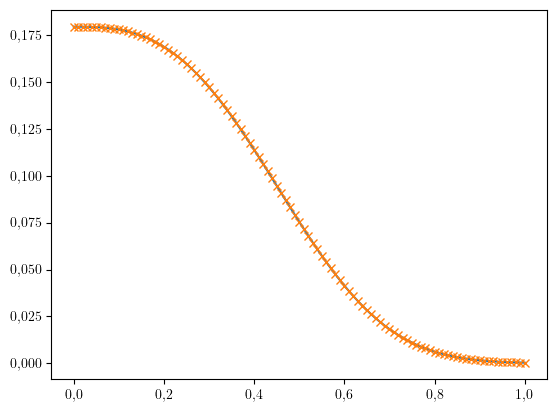

In [2]:
#Extraer datos de densidad y temperatura
r = np.loadtxt('te_ne_perfil_presion.txt', skiprows=1, usecols=0 )
Te = np.loadtxt('te_ne_perfil_presion.txt', skiprows=1, usecols=1 )
ne = np.loadtxt('te_ne_perfil_presion.txt', skiprows=1, usecols=2 )
 
#s - flujo normalizado
size = r.shape
radio_menor = r[size[0]-1] - r[0]
r_eff = np.linspace(0, radio_menor,r.shape[0])
s = r_eff/radio_menor

#Valor de presión
from scipy.constants import e
#factor_densidad = 1.0 #original
factor_densidad = 6.1405 #Escenario 1
p = factor_densidad*ne*Te*e
#p_c = factor_densidad*ne[0]*Te*e
#print(p_c[0])
#p = p_c[0]*np.power(10, (-2*s*s)) #según paper de canonical profiles
#p = p_c[0]*np.power(145, (-1*s**2.15))

#Ajuste polinomio
amn = np.polyfit(s, p, 10)
print(amn)
p_fit = np.poly1d(amn)

#plt.plot(s,p_c, "o")
plt.plot(s,p_fit(s))
plt.plot(s,p, "x")
#plt.plot(s,factor_densidad*ne)

0.02925886680876026
[2.92588662e-02 6.06567335e+02 2.88615897e+00]


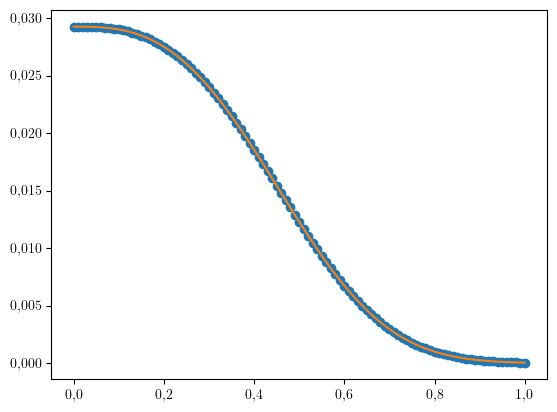

In [3]:
#Extraer datos de densidad y temperatura
r = np.loadtxt('te_ne_perfil_presion.txt', skiprows=1, usecols=0 )
Te = np.loadtxt('te_ne_perfil_presion.txt', skiprows=1, usecols=1 )
ne = np.loadtxt('te_ne_perfil_presion.txt', skiprows=1, usecols=2 )
 
#s - flujo normalizado
size = r.shape
radio_menor = r[size[0]-1] - r[0]
r_eff = np.linspace(0, radio_menor,r.shape[0])
s = r_eff/radio_menor

#Valor de presión
from scipy.constants import e
factor_densidad = 1.0 #original
#factor_densidad = 6.27 #según el límite de densidad
#p = factor_densidad*ne*Te*e*0.1
p_c = factor_densidad*ne*Te*e #En 100 no funciona
print(p_c[0])
#p = p_c[0]*np.power(10, (-2*s*s))

import scipy.optimize as opt
# Función para ajustar datos de presión
def pres_canonica(x, amplitud, razon, exponente):
    return amplitud * np.power(razon, (-x**exponente))

p0_p = [0.16976895765500602, 100, 2] #original
p0_Te = [15, 1, 2] #original
ParametrosOptimizados_p, pcov_p = opt.curve_fit(pres_canonica, s, p_c, p0_p)
ParametrosOptimizados_te, pcov_te = opt.curve_fit(pres_canonica, s, Te, p0_Te)


plt.plot(s,p_c, "o")
plt.plot(s, pres_canonica(s, *ParametrosOptimizados_p))
print(ParametrosOptimizados_p)

### Última superficie de flujo magnética del plasma del SCR-1

el valor de gamma es 0.0
[0.22924048]
La tringularidad es 0.4255553107713524
El valor mínimo de r es 0.19879119333022666
El valor máximo de r es 0.304804150906631


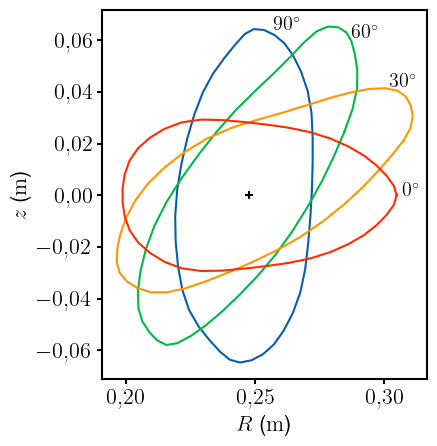

In [5]:
def LCMS_vmec(file):
    #librerías
    from pathlib import Path, PurePath #manejo de rutas y archivos
    import netCDF4 as nc
    
    #archivo netcdf 
    #Manual https://towardsdatascience.com/read-netcdf-data-with-python-901f7ff61648 
    ruta_archivo = PurePath(Path(file))
    datos_vmec = nc.Dataset(ruta_archivo)
    #Control archivo
    #print(datos_vmec)
    print("el valor de gamma es", datos_vmec['gamma'][:])
    
    #Extracción de variables de VMEC
    #https://github.com/jonathanschilling/vmec-internals/blob/master/vmec_var_names.pdf
    #Nodos radiales
    ns = datos_vmec['ns'][:]
    #Periodos del campo
    nfp = datos_vmec['nfp'][:]
    
    #Coordenadas
    #Poloidal mode numbers
    xm = datos_vmec['xm'][:]
    xm = np.expand_dims(xm, axis=1) #matriz
    #Toroidal mode numbers
    xn = datos_vmec['xn'][:]
    xn = np.expand_dims(xn, axis=1) #matriz
    #Poloidal modes
    mpol = datos_vmec['mpol'][:]
    #cosmn component of cylindrical R
    rmnc = datos_vmec['rmnc'][:]
    #sinmn component of cylindrical Z
    zmns = datos_vmec['zmns'][:]
        
    #construcción de coordenadas, formato coordenada(superficie, datos, ángulo)
    #https://github.com/jonathanschilling/vmec-internals/blob/master/scalars.pdf
    
    nu = 40 #ntheta en input VMEC
    nv = 24 * nfp #nzeta = 48
    theta = np.ndarray((nu,1))
    zeta = np.ndarray((nv,1))
    for i in range(nu): 
        theta[i] = (2*np.pi*i)/(nu-1)
    for i in range(nv): 
        zeta[i] = (2*np.pi*i)/(nv-1)
    
    
    #coordenada R
    r_vmec=0
    (___,mn)=rmnc.shape
    lt = len(theta)
    lz = len(zeta)
    mt= xm.dot(theta.T)
    nz=np.matmul(xn,zeta.T)
    cosmt=np.cos(mt)
    sinmt=np.sin(mt)
    cosnz=np.cos(nz)
    sinnz=np.sin(nz)
    r_vmec = np.zeros((ns,lt,lz))
    rmn = np.ndarray((mn,lt))
    for k_r in range(ns):
        rmn = np.broadcast_to(rmnc[k_r,:],(lt,mn)).T
        rmncosmt=(rmn*cosmt).T
        rmnsinmt=(rmn*sinmt).T
        #f[k,:,:]=np.matmul(fmncosmt, cosnz)-np.matmul(fmnsinmt, sinnz) #no funciona matmul
        r_vmec[k_r,:,:]= rmncosmt.dot(cosnz)- rmnsinmt.dot(sinnz)
    
    #coordenada Z
    z_vmec=0
    z_vmec = np.zeros((ns,lt,lz))
    zmn = np.ndarray((mn,lt))
    for k_z in range(ns):
        zmn = np.broadcast_to(zmns[k_z,:],(lt,mn)).T
        z_vmec[k_z,:,:]=(zmn*sinmt).T.dot(cosnz) + (zmn*cosmt).T.dot(sinnz)
    
    #Gráfico - Graficar para varios LCMS en distintos ángulos    
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.set_xlabel(r'$R$ (\si{\metre})', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel( r'$ z $ (\si{\metre})', 
                  fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=16, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    rango = range(0,r_vmec.shape[0],r_vmec.shape[0]-1) #LCMS
    color= np.array(['#0C5DA5', '#00B945', '#FF9500', '#FF2C00']) 
    cont_color = 0
    for n_plot in range(-12,2,4):
        #print(n_plot)
        ax.plot(r_vmec[rango,:,n_plot].T, z_vmec[rango,:,n_plot].T, linewidth=1.5, color= color[cont_color]) # 0 grados
        cont_color += 1
    plt.scatter(0.2477,0, marker="+", color = 'black')
    plt.gca().set_aspect("equal")
    plt.text(0.307,0, r'\Large \ang{0}')
    plt.text(0.302,0.042, r'\Large \ang{30}')
    plt.text(0.287,0.061, r'\Large \ang{60}')
    plt.text(0.257,0.064, r'\Large \ang{90}')
    #plt.savefig('LCMS.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP
    
    #Triangularidad
    fac = 98
    #plt.plot(r_vmec[fac,:,0], z_vmec[fac,:,0])
    #plt.plot(r_vmec[fac,:,0], z_vmec[fac,:,4])
    
    R_geo1 = (np.max(r_vmec[fac,:,0])+np.min(r_vmec[fac,:,0]))/2
    r_men = (np.max(r_vmec[fac,:,0])-np.min(r_vmec[fac,:,0]))/2
    idx = np.where(z_vmec[fac,:,0] == np.max(z_vmec[fac,:,0]))
    r_up1 = r_vmec[fac,:,0][idx[0]]
    print(r_up1)
    tri = (R_geo1-r_up1[0])/r_men
    print("La tringularidad es", tri)
    
    r_bi = np.min(r_vmec[rango,:,0].T)
    r_be = np.max(r_vmec[rango,:,0].T)
    print(f"El valor mínimo de r es {r_bi}")
    print(f"El valor máximo de r es {r_be}")
    
    #3D
    #fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #ang_tor = np.linspace(0, 2*np.pi, z_vmec.shape[2])
    #at = np.expand_dims(ang_tor, axis = (2,0))
    #print(r_vmec[rango,:,:].T)
    #x = r_vmec[rango,:,:].T * np.cos(at)
    #y = r_vmec[rango,:,:].T * np.sin(at)
    #z = z_vmec[rango,:,:].T
    return r_vmec, r_bi, r_be
r_v, r_inf, r_ext = LCMS_vmec('wout_scr_free.nc')

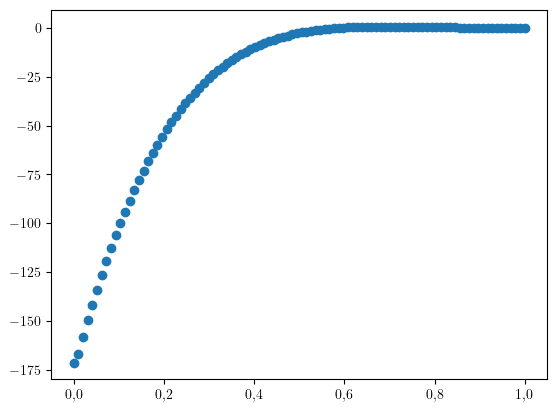

In [5]:
#Revisión del wout de VMEC
#librerías
from pathlib import Path, PurePath #manejo de rutas y archivos
import netCDF4 as nc
ruta_archivo = PurePath(Path('wout_scr_free.nc'))
datos_vmec = nc.Dataset(ruta_archivo)

#archivo netcdf 
#Manual https://towardsdatascience.com/read-netcdf-data-with-python-901f7ff61648 
#s - flujo normalizado
radio_menor1 = datos_vmec['Aminor_p'][:]
r_eff = np.linspace(0, radio_menor1, 98)
s1 = r_eff/radio_menor1
xm1 = datos_vmec['pres'][:]
amn = np.polyfit(s1, xm1[1:], 2)
pres_grad = np.gradient(xm1[1:], r_eff[1]-r_eff[0])
plt.plot(s1,pres_grad, "o")
#plt.plot(r_eff[1:],pres_fit(r_eff)[1:])

[0.22924048]
La tringularidad es 0.4255553107713524
El valor mínimo de r es 0.19879119333022666
El valor máximo de r es 0.304804150906631


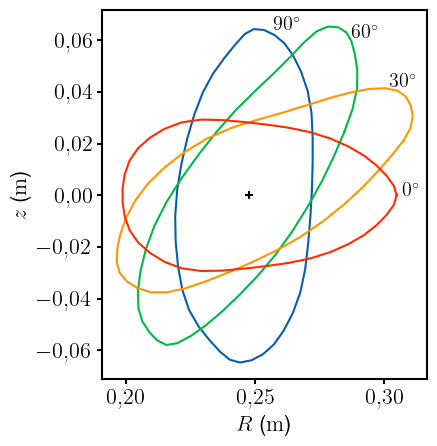

In [6]:
r_inf, r_ext = LCMS_vmec('wout_scr_free.nc')

## Análisis de los resultados de VMEC

Este libro cuenta con las principales herramientas para la graficación del archivo de salida de VMEC.

Basado en [pystell](https://github.com/PrincetonUniversity/STELLOPT/blob/develop/pySTEL/libstell_module_test.ipynb) de la librería de Stellopt.

### Profundidad del pozo magnético
Se calculó a partir de la expresión $$ U = \frac{ \frac{dV(0)}{d\Phi} - \frac{dV(r_{norm})}{d\Phi}  }{ \frac{dV(r_{norm})}{d\Phi} } \cdot 100 \%  $$ donde $r_{norm}$ es el radio normalizado y  $U$ es el volumen específico normalizado.

### Cizalla magnética
Se calculó a partir de la expresión $$ s = -\dfrac{r}{\iota} \dfrac{d \iota}{d r} $$ donde $r$ es la posición radial y  $\iota$ es la transformada rotacional.


In [6]:
#Datos de VMEC - coordenadas de superficies de flujo y campo magnético
def variables_vmec(file, r_bi, r_be):
    #librerías
    from pathlib import Path, PurePath #manejo de rutas y archivos
    import netCDF4 as nc
    
    #archivo netcdf 
    #Manual https://towardsdatascience.com/read-netcdf-data-with-python-901f7ff61648 
    ruta_archivo = PurePath(Path(file))
    datos_vmec = nc.Dataset(ruta_archivo)
    #Control archivo
    #print(datos_vmec)
    
    #Extracción de variables de VMEC
    #https://github.com/jonathanschilling/vmec-internals/blob/master/vmec_var_names.pdf
    
    #Nodos radiales
    ns = datos_vmec['ns'][:]
    #Periodos del campo
    nfp = datos_vmec['nfp'][:]
    
    #Coordenadas
    #Poloidal mode numbers
    xm = datos_vmec['xm'][:]
    xm = np.expand_dims(xm, axis=1) #matriz
    #Toroidal mode numbers
    xn = datos_vmec['xn'][:]
    xn = np.expand_dims(xn, axis=1) #matriz
    #Poloidal modes
    mpol = datos_vmec['mpol'][:]
    #cosmn component of cylindrical R
    rmnc = datos_vmec['rmnc'][:]
    #sinmn component of cylindrical Z
    zmns = datos_vmec['zmns'][:]
    
    #campo magnético
    bmnc = datos_vmec['bmnc'][:]
    xm_nyq = datos_vmec['xm_nyq'][:]
    xm_nyq = np.expand_dims(xm_nyq, axis=1) #matriz
    xn_nyq = datos_vmec['xn_nyq'][:]
    xn_nyq = np.expand_dims(xn_nyq, axis=1) #matriz

    #construcción de coordenadas, formato coordenada(superficie, datos, ángulo)
    #https://github.com/jonathanschilling/vmec-internals/blob/master/scalars.pdf
    
    nu = 40 #ntheta en input VMEC
    nv = 24 * nfp #nzeta = 48
    theta = np.ndarray((nu,1))
    zeta = np.ndarray((nv,1))
    for i in range(nu): 
        theta[i] = (2*np.pi*i)/(nu-1)
    for i in range(nv): 
        zeta[i] = (2*np.pi*i)/(nv-1)
    
    #coordenada R
    r_vmec=0
    (___,mn)=rmnc.shape
    lt = len(theta)
    lz = len(zeta)
    mt= xm.dot(theta.T)
    nz=np.matmul(xn,zeta.T)
    cosmt=np.cos(mt)
    sinmt=np.sin(mt)
    cosnz=np.cos(nz)
    sinnz=np.sin(nz)
    r_vmec = np.zeros((ns,lt,lz))
    rmn = np.ndarray((mn,lt))
    for k_r in range(ns):
        rmn = np.broadcast_to(rmnc[k_r,:],(lt,mn)).T
        rmncosmt=(rmn*cosmt).T
        rmnsinmt=(rmn*sinmt).T
        #f[k,:,:]=np.matmul(fmncosmt, cosnz)-np.matmul(fmnsinmt, sinnz) #no funciona matmul
        r_vmec[k_r,:,:]= rmncosmt.dot(cosnz)- rmnsinmt.dot(sinnz)
    
    #coordenada Z
    z_vmec=0
    z_vmec = np.zeros((ns,lt,lz))
    zmn = np.ndarray((mn,lt))
    for k_z in range(ns):
        zmn = np.broadcast_to(zmns[k_z,:],(lt,mn)).T
        z_vmec[k_z,:,:]=(zmn*sinmt).T.dot(cosnz) + (zmn*cosmt).T.dot(sinnz)
    
    
     #campo magnético
    b_vmec = 0
    (___,mnb)=bmnc.shape
    mt_nyq= xm_nyq.dot(theta.T)
    nz_nyq=np.matmul(xn_nyq,zeta.T)
    cosmt_nyq=np.cos(mt_nyq)
    sinmt_nyq=np.sin(mt_nyq)
    cosnz_nyq=np.cos(nz_nyq)
    sinnz_nyq=np.sin(nz_nyq)
    b_vmec = np.zeros((ns,lt,lz))
    bmn = np.ndarray((mnb,lt))
    for k_b in range(ns):
        bmn = np.broadcast_to(bmnc[k_r,:],(lt,mnb)).T
        bmncosmt=(bmn*cosmt_nyq).T
        bmnsinmt=(bmn*sinmt_nyq).T
        b_vmec[k_b,:,:]= bmncosmt.dot(cosnz_nyq)- bmnsinmt.dot(sinnz_nyq)
    #Plot superficies
    #plt.plot(r_vmec[r_vmec.shape[1]-1,1:-2, 0],b_vmec[b_vmec.shape[1]-1,1:-2,0], "-o")
    #bcampo = b_vmec[b_vmec.shape[1]-1,1:-2,0]
    #ycampo = 0.27843459*np.ones(bcampo.shape[0])
    #rcampo = r_vmec[r_vmec.shape[1]-1,1:-2, 0]
    #idx = np.argwhere(np.diff(np.sign(ycampo - rcampo ))).flatten() #intersección entre curvas
    #print(idx)
    #print(bcampo[idx])
    #print(rcampo[idx])
    
    #Valores de R y Z para corte toroidal    
    ang_tor = 0  
    
    Radio_mayor = datos_vmec['Rmajor_p'][:]
    
    #Interpolación
    r_inter = np.linspace(r_bi, r_be, 98)
    radio_menor = np.divide((r_be-r_bi),2)
    r = r_vmec[1:-2,r_vmec.shape[1]-1,ang_tor] - Radio_mayor
    r_eff = np.linspace(0, radio_menor, 100)
    
    r1 = r_vmec[2:-3,r_vmec.shape[1]-1,ang_tor] - Radio_mayor
    r_iota = np.linspace(0, radio_menor, 100) 
    
    
    #Triangularidad de LCMS
    R_geo = (r_be+r_bi)/2
    R_up = 0.233991
    triang = (R_geo-R_up)/radio_menor
    print("La triangularidad es", triang)
    
    #Variables
    #Iota - CAMBIAR
    f_iota = interpolate.interp1d(r, datos_vmec['iotas'][1:-2], fill_value='extrapolate')
    iota = f_iota(r_eff)
    #TR = np.divide(iota, 2*np.pi)
    TR = iota
    #print(iota)
    
    #Profundidad del pozo magnético
    #cosmn component of jacobian ( sqrt(g) )
    gsqrt = datos_vmec['gmnc'][:]
    sign = datos_vmec['signgs'][:]
    
    #signo jacobiano
    signo_jac = np.abs(gsqrt[:,1]) / gsqrt[:,1]   
    signo_jac= np.nan_to_num(signo_jac, posinf=1.0)*sign
    
    #flujo con unidades de T m^2
    phip_real = 2*np.pi*datos_vmec['phips'][:]*signo_jac
    #print(phip_real)
    
    #derivada del volumen respecto el flujo
    vp_real = np.power(2*np.pi,2)*datos_vmec['vp'][:]/phip_real  
    
    #Interpolación
    f_VS = interpolate.interp1d(r, vp_real[1:-2], fill_value='extrapolate')
    VS = f_VS(r_eff)
    U = np.divide((VS[0]-VS), VS[0])
    U2 = np.gradient( U, VS[0])
    print(U2)
    
    #Cizalla magnética
    s_0 = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=0)
    iota_0 = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=2)
    dr1 = (s_0[1]-s_0[0])*radio_menor
    d1_dr1 = ff.FinDiff(0, dr1, acc=4) #definir el operador y su orden
    diota1_dr1 = d1_dr1(iota_0) #derivada de iota respecto r
    s_int =  -((s_0*radio_menor)/iota_0)*diota1_dr1*signo_jac[:-2]
    
    f_s = interpolate.interp1d((s_0[2:-3]*radio_menor), s_int[2:-3], fill_value='extrapolate')
    s = f_s(r_eff)
    
    #f_iota_cm = interpolate.interp1d(r1, datos_vmec['iotas'][2:-3], fill_value='extrapolate')
    #iota_cm = f_iota_cm(r_iota)
    #dr = r_iota[2] - r_iota[1]
    #d_dr = ff.FinDiff(0, dr, acc=4) #definir el operador y su orden
    #diota_dr = d_dr(iota_cm) #derivada de iota respecto r
    
    
    dflujo = phip_real[2]*(1/(ns-1))
    d_dflujo = ff.FinDiff(0, dflujo, acc=6) #definir el operador y su orden
    diota_dflujo = d_dflujo(iota_0) #derivada de iota respecto flujo
    dr_iota_dflujo = d_dflujo((s_0)*radio_menor)
    
    #Comprobación derivada de iota respecto r
    #print(diota_dflujo)
    #print(diota1_dr1*dr_iota_dflujo)
    
    #Beta
    f_beta = interpolate.interp1d(r, datos_vmec['beta_vol'][1:-2], fill_value='extrapolate')   
    beta = f_beta(r_eff)*100
    #print(beta)
    
    #Presión - CAMBIAR
    f_P = interpolate.interp1d(r, datos_vmec['pres'][1:-2], fill_value='extrapolate')
    P = f_P(r_eff)
    
    #Pozo magnético
    well_inicial = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=5)
    s_0 = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=0)
    f_well = interpolate.interp1d(s_0[2:-2], well_inicial[2:-2], fill_value='extrapolate')
    well = f_well(r_eff)
    
    #plt.plot(x_inter, np.gradient(U), 'o')
    #print(datos_vmec['vol_p'])
    #jdotb = datos_vmec['jdotb'][:]
    #D_merc = datos_vmec['DCurr'][:]
    #print(D_merc)
    
    #campo magnético
    b_vmec = 0
    (___,mnb)=bmnc.shape
    mt_nyq= xm_nyq.dot(theta.T)
    nz_nyq=np.matmul(xn_nyq,zeta.T)
    cosmt_nyq=np.cos(mt_nyq)
    sinmt_nyq=np.sin(mt_nyq)
    cosnz_nyq=np.cos(nz_nyq)
    sinnz_nyq=np.sin(nz_nyq)
    b_vmec = np.zeros((ns,lt,lz))
    bmn = np.ndarray((mnb,lt))
    for k_b in range(ns):
        bmn = np.broadcast_to(bmnc[k_r,:],(lt,mnb)).T
        bmncosmt=(bmn*cosmt_nyq).T
        bmnsinmt=(bmn*sinmt_nyq).T
        b_vmec[k_b,:,:]= bmncosmt.dot(cosnz_nyq)- bmnsinmt.dot(sinnz_nyq)
   
    return VS[0], vp_real, phip_real, r_eff, TR, U, s, P, Radio_mayor, beta, well
    
flujo, dV, phi, r_eff, TR, U, s, P, R_mayor, beta, W = variables_vmec('wout_scr_free.nc', r_inf, r_ext)

La triangularidad es 0.3359338806408725
[-6.41033647e-06 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06
 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06
 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06
 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06
 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06 -6.41033647e-06
 -6.85939747e-06 -7.87762151e-06 -8.44678454e-06 -8.69098119e-06
 -9.50500450e-06 -1.00748312e-05 -1.05237764e-05 -1.12037983e-05
 -1.16323624e-05 -1.22132491e-05 -1.27193413e-05 -1.32182312e-05
 -1.37325846e-05 -1.41607769e-05 -1.46455454e-05 -1.50101210e-05
 -1.54419119e-05 -1.58157546e-05 -1.61119588e-05 -1.64492036e-05
 -1.66996537e-05 -1.69024858e-05 -1.71115517e-05 -1.72653880e-05
 -1.73545757e-05 -1.74172226e-05 -1.74422238e-05 -1.74193308e-05
 -1.73534589e-05 -1.72524940e-05 -1.71156059e-05 -1.69432445e-05
 -1.67369754e-05 -1.64991812e-05 -1.62327592e-05 -1.59408119e-05
 -1.56265797e-05 -1.52934954e-05 -1.49449348e-05 -

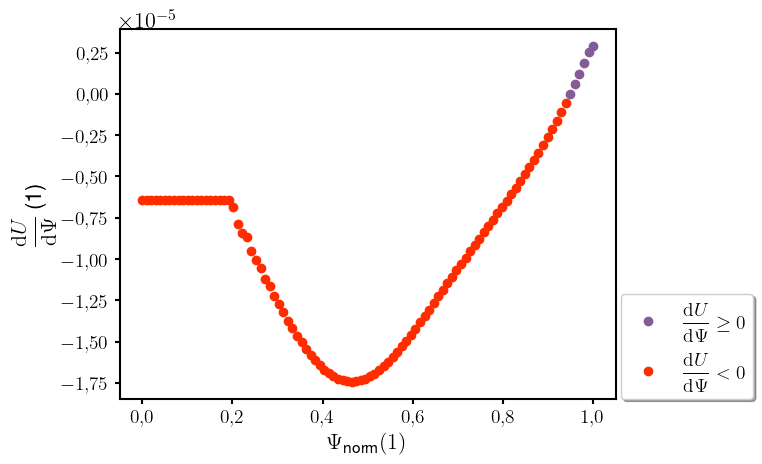

In [7]:
#Gradiente de la profundidad del pozo magnético, Revisar si se cambia por well2006
def gradiente_pozo_magnetico(r_mayor, r_bi, r_be, r_ef, pozo_mag, f):
    gradiente = np.gradient(pozo_mag, f)
    pos_grad = np.where(gradiente >= 0.000)
    neg_grad = np.where(gradiente < 0) 
    radio_menor = np.divide((r_be-r_bi),2) 
    var_rad = r_ef[neg_grad]/radio_menor
    #print(radio_menor)
    #print(r_mayor)
    #print(r_ef[neg_grad]+r_mayor)
    #print(r_eff[pos_grad])
    #print(r_eff[pos_grad]+ 0.24953903)

    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure   
    ax.plot(r_ef[pos_grad]/radio_menor, gradiente[pos_grad], 'o', linewidth=10, color= '#845B97', label = 'datos originales') #gradiente positivo
    ax.plot(r_ef[neg_grad]/radio_menor, gradiente[neg_grad], 'o', linewidth=1.5, color= '#FF2C00') #datos interpolados
    ax.set_xlabel(r'$ \Psi_{\text{norm}}(1)$', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel(r'$ \dfrac{ \mathrm{d}U}{\mathrm{d}\Psi} $ (1)', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax.tick_params(axis='both', labelsize=14, width=1.5)
    ax.legend((r'$ \dfrac{ \mathrm{d}U}{\mathrm{d}\Psi} \geq 0$', r'$ \dfrac{ \mathrm{d}U}{\mathrm{d}\Psi} < 0$'), loc=(1.01,0), fontsize=14,  ncol=1, fancybox=True, shadow=True)
    ax.yaxis.get_offset_text().set_fontsize(16)
    plt.setp(ax.spines.values(), linewidth=1.5)
    plt.savefig('grad_U.png', dpi=300, bbox_inches='tight')
    
gradiente_pozo_magnetico(R_mayor, r_inf, r_ext, r_eff, U, flujo)

0.318764423470461 0.2708168172392372
[0.80808081]
[0.29066655]
[0.57575758]
[0.27835191]
[0.96969697]
[0.29923325]


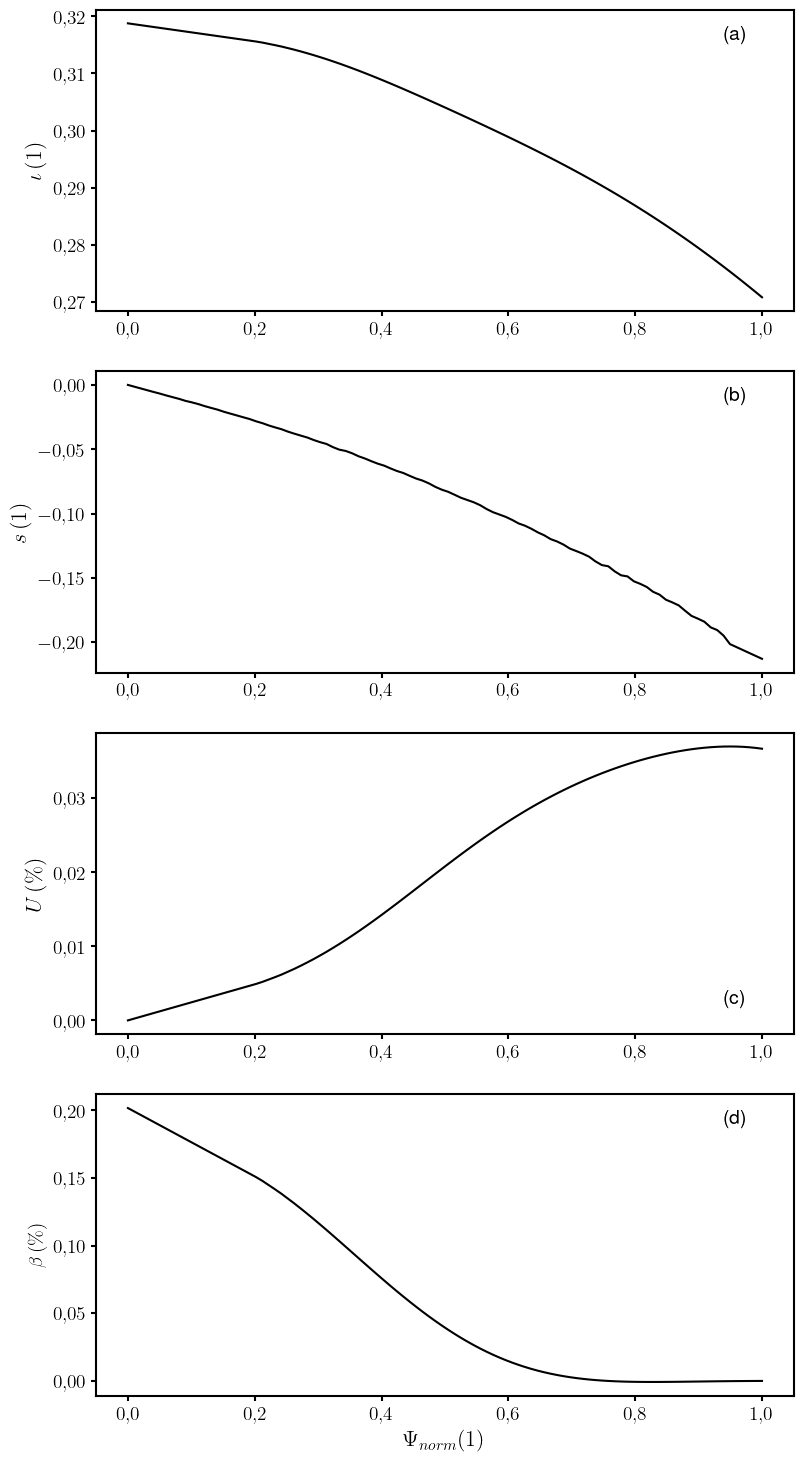

In [9]:
#Gráficación
def graficacion_vmec_B(r_eff, TR, U, s, P, beta, well, r_bi, r_be, Radio_mayor):
    # Crear la figura y los ejes
    #iota_1 = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=2 )
    #s_1 = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=3)
    
    #radio_menor = r_be - Radio_mayor 
    radio_menor = np.divide((r_be-r_bi),2)
    #Máximo y mínimo de iota
    print(np.max(TR), np.min(TR))
    
    #Valores racionales
    #Intersección
    y = (3/10)*np.ones(100)
    y_1 = (2/7)*np.ones(100)
    y_2 = (3/(11))*np.ones(100)
    #print(r_eff.shape)
    idx = np.argwhere(np.diff(np.sign(y - TR ))).flatten() #intersección entre curvas
    idx1 = np.argwhere(np.diff(np.sign(y_1 - TR ))).flatten() #intersección entre curvas
    idx2 = np.argwhere(np.diff(np.sign(y_2 - TR ))).flatten() #intersección entre curvas
    flux = r_eff/radio_menor
    print(flux[idx1] )
    print(r_eff[idx1]+ Radio_mayor)
    print(flux[idx] )
    print(r_eff[idx]+ Radio_mayor)
    print(flux[idx2] )
    print(r_eff[idx2]+ Radio_mayor)
   
    #idx = np.argwhere(np.diff(np.sign(y - well_int ))).flatten() #intersección entre curvas
    
    
    #Graficación
    fig, ax = plt.subplots(4, figsize=(9, 18))
    ax[0].plot(r_eff/radio_menor, TR, '-', linewidth=1.5, color= 'black') #transformada rotacional
    ax[1].plot(r_eff/radio_menor, s, linewidth=1.5, color='black') #cizalla magnética
    ax[2].plot(r_eff/radio_menor, U, linewidth=1.5, color='black') # profundidad del pozo magnético
    #ax[2].plot(r_eff/radio_menor, well, linewidth=1.5, color='black') # pozo magnético
    ax[3].plot(r_eff/radio_menor, beta, linewidth=1.5, color='black') #beta
    #ax[4].plot(r_eff/radio_menor, P, linewidth=1.5, color='black') #Presión
    #ax[0].plot(r_eff/radio_menor, y_1)
    #ax[0].plot(r_eff/radio_menor, y)
    #ax[0].plot(r_eff/radio_menor, y_2)
    #Ejes rotulados
    ax[3].set_xlabel(r'$\Psi_{norm} (1)$', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    
    #ax[0].set_ylabel(r'$\text{\sout{\ensuremath{\iota}}}  \left( 1 \right)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax[0].set_ylabel(r'$\iota  \left( 1 \right)$', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax[1].set_ylabel(r'$s \left( 1 \right)$', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax[2].set_ylabel(r'$ U \left( \% \right) $', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax[3].set_ylabel(r'$ \beta \left( \si{\percent} \right) $', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    #ax[4].set_ylabel(r'$ \beta \left( \si{\%} \right) $', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax[0].tick_params(axis='both', labelsize=14, width=1.5)
    ax[1].tick_params(axis='both', labelsize=14, width=1.5)
    ax[2].tick_params(axis='both', labelsize=14, width=1.5) 
    ax[3].tick_params(axis='both', labelsize=14, width=1.5)
    #ax[4].tick_params(axis='both', labelsize=14, width=1.5)
    plt.setp(ax[0].spines.values(), linewidth=1.5)
    plt.setp(ax[1].spines.values(), linewidth=1.5)
    plt.setp(ax[2].spines.values(), linewidth=1.5)
    plt.setp(ax[3].spines.values(), linewidth=1.5)
    #plt.setp(ax[4].spines.values(), linewidth=1.5)
    #ticks eje y
    #yticks_0 = np.arange(0.042, 0.052, 0.002)
    #ax[0].axis('equal')
    #yticks_0 = np.arange(0.25, 0.38, 0.05)
    #yticks_1 = np.arange(0, -0.5, -0.1)
    #ax[0].set_yticks(yticks_0)
    #ax[1].set_yticks(yticks_1)
    #ax[2].set_yticks(yticks_1)
    #ticks eje x
    #ax[0].set_ylim(0,0.8)
    #eje_R = np.arange(0.247692, 0.307692, 0.01)
    #ax[0].set_xticks(eje_R)
    #ax[1].set_xticks(eje_R)
    #ax[2].set_xticks(eje_R)
    #ax[3].set_xticks(eje_R)
    
    #ejes tamaño etiquetas
    #eje_x = np.arange(0, 1.1, 0.1)
    #ax[0].set_xticks(eje_x)
    #ax[3].set_xticks(eje_x)
    ax[0].tick_params(axis='both', labelsize=14)
    ax[1].tick_params(axis='both', labelsize=14)
    ax[2].tick_params(axis='both', labelsize=14)
    ax[3].tick_params(axis='both', labelsize=14)
    #ax[3].tick_params(axis='both', labelsize=14)
    ax[0].text(0.9,0.9, r"$\text{(a)}$", fontsize =14, fontdict=None, transform=ax[0].transAxes ) #Etiquetar gráfica
    ax[1].text(0.9,0.9, r'$\text{(b)}$', fontsize =14, fontdict=None, transform=ax[1].transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
    ax[2].text(0.9,0.1, r'$\text{(c)}$', fontsize =14, fontdict=None, transform=ax[2].transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
    ax[3].text(0.9,0.9, r"$\text{(d)}$", fontsize =14, fontdict=None, transform=ax[3].transAxes ) #Etiquetar gráfica
    #ax[4].text(0.9,0.9, r"$\text{(e)}$", fontsize =14, fontdict=None, transform=ax[4].transAxes ) #Etiquetar gráfica
    
    #ax[0].set_aspect(1 / ax[0].get_data_ratio())
    #ax[1].set_aspect(1 / ax[1].get_data_ratio())
    #ax[2].set_aspect(1 / ax[2].get_data_ratio())
    #ax[3].set_aspect(1 / ax[3].get_data_ratio())
    #ax[4].set_aspect(1 / ax[4].get_data_ratio())
    
    # Guardar el gráfico en formato png
    plt.savefig('Variables_Equilibrio.png', dpi=300, bbox_inches='tight')
    
    #z2 = np.polyfit(r_eff/radio_menor, jdotb, 9)
    #jdotB_fit = np.poly1d(z2)
    
    
    # Mostrar el gráfico
    #plt.plot(r_eff/radio_menor, jdotB_fit(r_eff/radio_menor))
    plt.show()
graficacion_vmec_B(r_eff, TR, U, s, P, beta, W, r_inf, r_ext, R_mayor)

0.318764423470461 0.2708168172392372
[0.80808081]
[0.29066655]
[0.57575758]
[0.27835191]
[0.96969697]
[0.29923325]


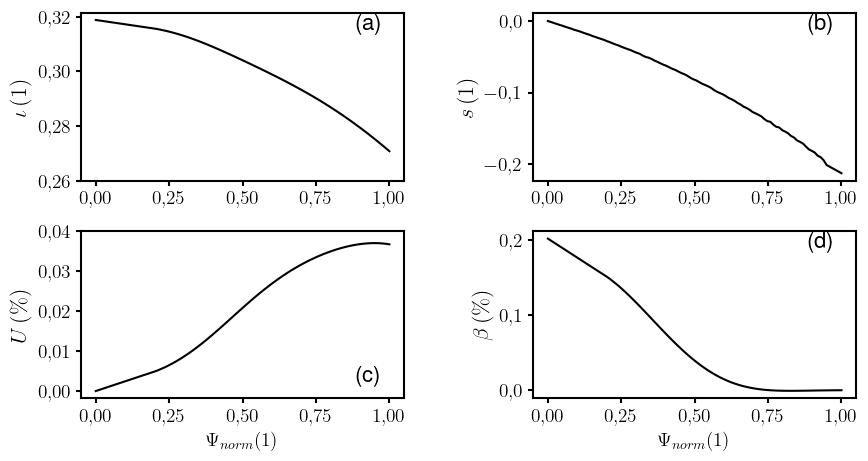

In [8]:
#Gráficación
def graficacion_vmec_B_ingles(r_eff, TR, U, s, P, beta, well, r_bi, r_be, Radio_mayor):
    # Crear la figura y los ejes
    #iota_1 = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=2 )
    #s_1 = np.loadtxt('mercier_0.scr_free', skiprows=2, usecols=3)
    
    #radio_menor = r_be - Radio_mayor 
    radio_menor = np.divide((r_be-r_bi),2)
    #Máximo y mínimo de iota
    print(np.max(TR), np.min(TR))
    
    #Valores racionales
    #Intersección
    y = (3/10)*np.ones(100)
    y_1 = (2/7)*np.ones(100)
    y_2 = (3/(11))*np.ones(100)
    #print(r_eff.shape)
    idx = np.argwhere(np.diff(np.sign(y - TR ))).flatten() #intersección entre curvas
    idx1 = np.argwhere(np.diff(np.sign(y_1 - TR ))).flatten() #intersección entre curvas
    idx2 = np.argwhere(np.diff(np.sign(y_2 - TR ))).flatten() #intersección entre curvas
    flux = r_eff/radio_menor
    print(flux[idx1] )
    print(r_eff[idx1]+ Radio_mayor)
    print(flux[idx] )
    print(r_eff[idx]+ Radio_mayor)
    print(flux[idx2] )
    print(r_eff[idx2]+ Radio_mayor)
   
    #idx = np.argwhere(np.diff(np.sign(y - well_int ))).flatten() #intersección entre curvas
    
    
    #Graficación
    tam = 5
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(2*tam, 1*tam))#figsize=(9, 18)
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=0.4)
    ax[0,0].plot(r_eff/radio_menor, TR, '-', linewidth=1.5, color= 'black') #transformada rotacional
    ax[0,1].plot(r_eff/radio_menor, s, linewidth=1.5, color='black') #cizalla magnética
    ax[1,0].plot(r_eff/radio_menor, U, linewidth=1.5, color='black') # profundidad del pozo magnético
    ax[1,1].plot(r_eff/radio_menor, beta, linewidth=1.5, color='black') #beta
   
    ax[0,0].set_ylabel(r'$\iota  \left( 1 \right)$', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax[0,1].set_ylabel(r'$s \left( 1 \right)$', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax[1,0].set_ylabel(r'$ U \left( \% \right) $', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax[1,1].set_ylabel(r'$ \beta \left( \si{\percent} \right) $', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    
    eje_y_iota = np.arange(0.26, np.max(TR)+0.01, 0.02)
    eje_y_U = np.arange(0, np.max(U)+0.01, 0.01)
    ax[1,0].set_yticks(eje_y_U)
    ax[0,0].set_yticks(eje_y_iota)
    ax[1,0].set_xlabel(r'$\Psi_{norm} (1)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax[1,1].set_xlabel(r'$\Psi_{norm} (1)$', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax[0,0].tick_params(axis='both', labelsize=16, width=1.5)
    ax[0,1].tick_params(axis='both', labelsize=16, width=1.5)
    ax[1,0].tick_params(axis='both', labelsize=16, width=1.5) 
    ax[1,1].tick_params(axis='both', labelsize=16, width=1.5)
    plt.setp(ax[0,0].spines.values(), linewidth=1.5)
    plt.setp(ax[0,1].spines.values(), linewidth=1.5)
    plt.setp(ax[1,0].spines.values(), linewidth=1.5)
    plt.setp(ax[1,1].spines.values(), linewidth=1.5)

    #ejes tamaño etiquetas
    ax[0,0].tick_params(axis='both', labelsize=14)
    ax[0,1].tick_params(axis='both', labelsize=14)
    ax[1,0].tick_params(axis='both', labelsize=14)
    ax[1,1].tick_params(axis='both', labelsize=14)
    ax[0,0].text(0.85,0.9, r"$\text{(a)}$", fontsize =16, fontdict=None, transform=ax[0,0].transAxes ) #Etiquetar gráfica
    ax[0,1].text(0.85,0.9, r'$\text{(b)}$', fontsize =16, fontdict=None, transform=ax[0,1].transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
    ax[1,0].text(0.85,0.1, r'$\text{(c)}$', fontsize =16, fontdict=None, transform=ax[1,0].transAxes) #Etiquetar gráfica fontdict = none para que intrpete latex
    ax[1,1].text(0.85,0.9, r"$\text{(d)}$", fontsize =16, fontdict=None, transform=ax[1,1].transAxes ) #Etiquetar gráfica
    
    #ax[0].set_aspect(1 / ax[0].get_data_ratio())
    #ax[1].set_aspect(1 / ax[1].get_data_ratio())
    #ax[2].set_aspect(1 / ax[2].get_data_ratio())
    #ax[3].set_aspect(1 / ax[3].get_data_ratio())
    #ax[4].set_aspect(1 / ax[4].get_data_ratio())
    
    # Guardar el gráfico en formato png
    #plt.savefig('Variables_Equilibrio.eps', format='eps', dpi=300, bbox_inches='tight')
    plt.savefig('Variables_Equilibrio.png', dpi=300, bbox_inches='tight')
    
    #z2 = np.polyfit(r_eff/radio_menor, jdotb, 9)
    #jdotB_fit = np.poly1d(z2)
    
    
    # Mostrar el gráfico
    #plt.plot(r_eff/radio_menor, jdotB_fit(r_eff/radio_menor))
    plt.show()
graficacion_vmec_B_ingles(r_eff, TR, U, s, P, beta, W, r_inf, r_ext, R_mayor)

# Criterio de Mercier

\begin{align} 
    D_{\text{Mercier}} = D_{\text{CM}} + D_{\text{IT}} + D_{\text{PM}} + D_{\text{G}} > 0
\end{align}

\begin{align}
        &D_{\text{CM}} = \frac{1}{16 \pi^2} \left( \dfrac{\mathrm d \iota}{ \mathrm d \Psi} \right)^2 \\
        &D_{\text{IT}} = -\frac{s_G}{16 \pi^4} \dfrac{\mathrm d \iota}{ \mathrm d \Psi} \mathop{ \int }  \dfrac{ \mathrm{d} A }{ \left| \nabla \Psi \right|^3 } \left( \mu_0 \vec{J} - \dfrac{\mathrm d I \left( \Psi \right)}{\mathrm d \Psi} \vec{B} \right) \cdot \vec{B} \\
        &D_{\text{PM}} =  \frac{\mu_0}{64 \pi^6} \dfrac{\mathrm d P}{ \mathrm d \Psi} \left( s_\Psi \dfrac{\mathrm d^2 V}{ \mathrm d \Psi^2} - \mu_0 \dfrac{\mathrm d P}{ \mathrm d \Psi}  \mathop{  \int } \dfrac{\mathrm d A}{ B^2 \left| \nabla \Psi \right|}  \right) \mathop{ \int } \dfrac{B^2 }{  \left| \nabla \Psi \right|^3} \mathrm d A \\
        &D_{\text{G}} = \dfrac{1}{64 \pi^6} \left( \mathop{ \int } \dfrac{\mu_0 \vec{J} \cdot \vec{B}}{ \left| \nabla \Psi \right|^3} \mathrm d A  \right)^2 - \dfrac{1}{64 \pi^6}   \left( \mathop{ \int } \dfrac{B^2}{ \left| \nabla \Psi \right|^3} \mathrm d A  \right) \mathop{ \int } \dfrac{ \left( \mu_0 \vec{J} \cdot \vec{B} \right)^2 }{ B^2 \left| \nabla \Psi \right|^3} \mathrm d A
    \end{align}

[0.92982473 0.94981649 0.96980824 0.9898    ]


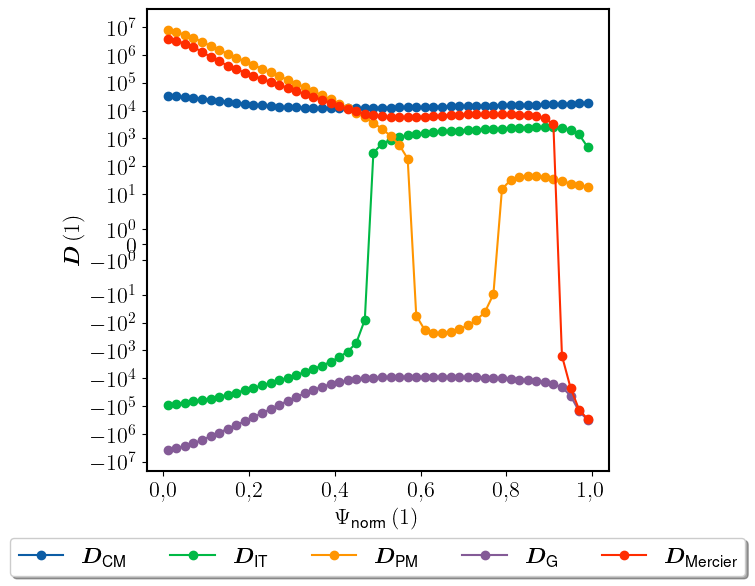

In [123]:
# Criterio de Mercier para equilibrio en modo free y fixed - SIMPLIFIFCAR
#https://github.com/PrincetonUniversity/STELLOPT/blob/develop/VMEC2000/Sources/Input_Output/mercier.f
def Mercier_graficacion(file):
    #Archivo Mercier
    ruta_archivo = PurePath(Path(file))
    datos_free = np.loadtxt(ruta_archivo, skiprows=2) 
    #datos_fixed = np.loadtxt('mercier_D.scr_fixed', skiprows=2)
    #Free boundary
    #phi_norm = datos_free[:,0]
    a = np.min(datos_free[:,0])
    b = np.max(datos_free[:,0])
    phi_norm = np.linspace( a, b, 50) 
    phi_norm_red = datos_free[7:-2,0]

    #cizalla magnética
    D_CM_inicial = datos_free[7:-2,2]
    f_D_CM = interpolate.interp1d(phi_norm_red, D_CM_inicial, fill_value='extrapolate')
    D_CM = f_D_CM(phi_norm)
    
    #Corriente toroidal
    D_IT_inicial = datos_free[7:-2,3]
    f_D_IT = interpolate.interp1d(phi_norm_red, D_IT_inicial, fill_value='extrapolate')
    D_IT = f_D_IT(phi_norm)
    
    #Pozo magnético
    D_PM_inicial = datos_free[7:-2,4]
    f_D_PM = interpolate.interp1d(phi_norm_red, D_PM_inicial, fill_value='extrapolate')
    D_PM = f_D_PM(phi_norm)
    
    #Curvatura
    D_G_inicial = datos_free[7:-2,5]
    f_D_G = interpolate.interp1d(phi_norm_red, D_G_inicial, fill_value='extrapolate')
    D_G = f_D_G(phi_norm)
    
    #Mercier total
    D_fr_inicial = datos_free[7:-2,1]
    f_D = interpolate.interp1d(phi_norm_red, D_fr_inicial, fill_value='extrapolate')
    D_fr = f_D(phi_norm)
    idx22 = np.where(D_fr < 0)
    
    print(phi_norm[idx22[0]])
    
    #Graficación
    fig, ax = plt.subplots(1,1, figsize=(6, 6))
    ax.set_prop_cycle(color=['0C5DA5', '00B945', 'FF9500', '845B97', 'FF2C00'])
    ax.plot(phi_norm, D_CM, '-o') #transformada rotacional
    ax.plot(phi_norm, D_IT, '-o') #corriente toroidal
    ax.plot(phi_norm, D_PM, '-o') #pozo magnético
    ax.plot(phi_norm, D_G, '-o') # curvatura
    ax.plot(phi_norm, D_fr, '-o') # total
    plt.setp(ax.spines.values(), linewidth=1.5) #recuadro enmarcado
    ax.set_yscale('symlog')
    #eje_y_M = np.arange(np.min(D_fr), np.max(D_fr), 1000)
    #ax.set_yticks(eje_y_M)
    ax.set_xlabel(r'$ \Psi_{\text{norm}} \left( 1 \right)  $', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    ax.set_ylabel(r'$ \boldsymbol{D} \left( 1 \right)$', fontdict = {'fontsize':16, 'fontweight':'bold', 'color':'black'})
    if idioma == 'español':
        ax.legend((r'$ \boldsymbol{ D_{\text{CM}} }$', r'$\boldsymbol{ D_{\text{IT}} }$', r'$ \boldsymbol{ D_{\text{PM}} }$' , 
             r'$ \boldsymbol{ D_{\text{G}} }$', r'$ \boldsymbol{ D_{\text{Mercier}} }$'), fontsize = 16, 
             loc='upper center',  bbox_to_anchor=(0.5, -0.12), ncol=5, fancybox=True, shadow=True)
    if idioma == 'ingles':
        ax.legend((r'$ \boldsymbol{ D_{\text{shear}} }$', r'$\boldsymbol{ D_{\text{curr}} }$', r'$ \boldsymbol{ D_{\text{well}} }$' , 
             r'$ \boldsymbol{ D_{\text{geod}} }$', r'$ \boldsymbol{ D_{\text{Merc}} }$'), fontsize = 16, 
             loc='upper center',  bbox_to_anchor=(0.5, -0.12), ncol=5, fancybox=True, shadow=True)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_aspect(1 / ax.get_data_ratio())
    
    # Guardar el gráfico en formato png
    if idioma == 'español':
        plt.savefig('Mercier_free.png', dpi=300, bbox_inches='tight')
    if idioma == 'ingles':
        plt.savefig('Mercier_free.eps', format='eps', dpi=300, bbox_inches='tight')
    
Mercier_graficacion('mercier_D.scr_free')

In [ ]:
#Paleta de colores
#axes.prop_cycle : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e'])

#ax[0].set_prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
#ax[0].plot(phi_norm, D_CM_fr, '-o') #transformada rotacional
#ax[0].plot(phi_norm, D_IT_fr, '-o') #corriente toroidal
#ax[0].plot(phi_norm, D_PM_fr, '-o') #pozo magnético
#ax[0].plot(phi_norm, D_G_fr, '-o') # curvatura
#ax[0].plot(phi_norm, D_fr, '-o') # total
#ax[0].set_yscale('symlog')
#ax[0].set_xlabel(r'$\Psi_{\text{norm}}$')
#ax[0].set_ylabel(r'$ \ln \, (D)$')
#ax[0].legend((r'$D_{\text{CM}}$', r'$D_{\text{IT}}$', r'$D_{\text{PM}}$' , r'$D_{\text{G}}$', r'$D_{\text{Mercier}}$'), 
             #loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fancybox=True, shadow=True)
#ax[1].set_prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
#ax[1].plot(phi_norm, D_CM_fi, '-o') #transformada rotacional
#ax[1].plot(phi_norm, D_IT_fi, '-o') #corriente toroidal
#ax[1].plot(phi_norm, D_PM_fi, '-o') #pozo magnético
#ax[1].plot(phi_norm, D_G_fi, '-o') # curvatura
#ax[1].plot(phi_norm, D_fi, '-o') # total
#ax[1].set_yscale('symlog')
#ax[1].set_xlabel(r'$\Psi_{\text{norm}}$')
#ax[1].set_ylabel(r'$ D $')
#ax[1].legend((r'$D_{\text{CM}}$', r'$D_{\text{IT}}$', r'$D_{\text{PM}}$' , r'$D_{\text{G}}$', r'$D_{\text{Mercier}}$'), 
#loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, fancybox=True, shadow=True)

In [ ]:
"""
#Fixed boundary
D_CM_fi = datos_fixed[10:-12,2]
f_D_CM_fi = interpolate.interp1d(phi_norm_red, D_CM_fi, fill_value='extrapolate')
D_CM_fi = f_D_CM_fi(phi_norm)

D_IT_fi = datos_fixed[10:-12,3]
f_D_IT_fi = interpolate.interp1d(phi_norm_red, D_IT_fi, fill_value='extrapolate')
D_IT_fi = f_D_IT_fi(phi_norm)

D_PM_fi = datos_fixed[10:-12,4]
f_D_PM_fi = interpolate.interp1d(phi_norm_red, D_PM_fi, fill_value='extrapolate')
D_PM_fi = f_D_PM_fi(phi_norm)

D_G_fi = datos_fixed[10:-12,5]
f_D_G_fi = interpolate.interp1d(phi_norm_red, D_G_fi, fill_value='extrapolate')
D_G_fi = f_D_G_fi(phi_norm)

D_fi = datos_fixed[10:-12,1]
f_D_fi = interpolate.interp1d(phi_norm_red, D_fi, fill_value='extrapolate')
D_fi = f_D_fi(phi_norm)
"""